In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path = './test.csv'

In [154]:
pop = pd.read_csv(path)
pop.parent_id[pop.parent_id < 0] = np.nan

n_ages = pop.age.unique().size

/home/asajina/pyenvs/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## track traits per age over time

   timepoint  popsize     variance
0   0.000000      999     0.000000
1   0.217946      403     7.846339
2   0.435893      369    37.052387
3   0.653839      328    86.932620
4   0.871786      288   208.952245
5   1.089732      246   341.730865
6   1.307678      196   549.687292
7   1.525625      146   886.945956
8   1.743571      109  2005.724434
9   1.961518       60  2000.350000


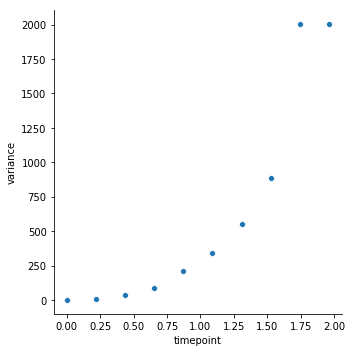

In [150]:
def trait_timeline(n_timepoints=10):
    # fill in for starting population
    survival = pop[pop.birth_date == 0].groupby('age').mean().survival
    reproduction = pop[pop.birth_date == 0].groupby('age').mean().reproduction
    popsize = [np.sum(pop.birth_date == 0) / n_ages]
    variance = [0]
    
    timepoints = np.linspace(0, max(pop.birth_date.max(), pop.death_date.max()), n_timepoints+1)
    for i in range(1, n_timepoints):
        snap_pop = pop[np.logical_and(pop.birth_date <= timepoints[i], pop.death_date > timepoints[i])]
        survival = np.hstack((survival, snap_pop.groupby('age').mean().survival))
        reproduction = np.hstack((reproduction, snap_pop.groupby('age').mean().reproduction))
        popsize.append(np.sum(np.logical_and(pop.birth_date <= timepoints[i], pop.death_date > timepoints[i])) / n_ages)
        variance.append(np.var(snap_pop[snap_pop.age == 0].id))
        
    dft = pd.DataFrame()
    dft['age'] = np.tile(np.tile(pop.age.unique(), n_timepoints), 2)
    dft['timepoint'] = np.tile(np.repeat(timepoints[:-1], n_ages), 2)
    dft['trait'] = np.concatenate((survival, reproduction))
    dft['type'] = np.repeat(['survival', 'reproduction'], n_ages * pop.age.unique().size)
    
    dfps = pd.DataFrame()
    dfps['timepoint'] = timepoints[:-1]
    dfps['popsize'] = np.array(popsize)
    dfps['variance'] = np.array(variance)
    return dft, dfps

df_traits, df_popsize = trait_timeline()
print df_popsize
#sns.relplot(data=df_traits, x='timepoint', y='trait', hue='age', kind='line', col='type')
sns.relplot(data=df_popsize, x='timepoint', y='variance')